# Imports

Staples

In [87]:
import pandas as pd
import numpy as np

Visualisation

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

Preprocessing

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer #This is to vectorise our characters and make them readable for our models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

Models

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Data exploration

In [91]:
df = pd.DataFrame(
    pd.read_csv(
        "passwords.csv",
        on_bad_lines = 'skip'
        ))
df

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1
...,...,...
669635,10redtux10,1
669636,infrared1,1
669637,184520socram,1
669638,marken22a,1


### Missing values

In [92]:
print(df.isna().sum())
print(df[df.password.isna()])
df.dropna(inplace = True)

password    1
strength    0
dtype: int64
       password  strength
367579      NaN         0


We are missing a single password. We can just drop it.

### Duplicates

In [119]:
df.duplicated().sum()

0

There exist no duplicated instances. 

### Balance

The below is a density histogram and a pie chart. We can see the ratio between the strength of passwords. 

<AxesSubplot:xlabel='strength', ylabel='Density'>

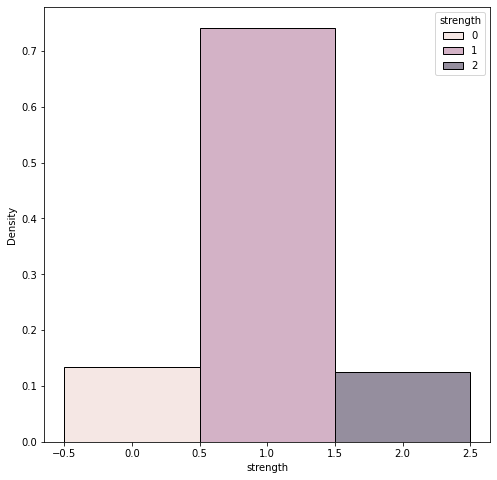

In [117]:
plt.figure(figsize=(8, 8))

sns.histplot(
    df,
    x = 'strength',
    discrete = True,
    hue = 'strength',
    element = 'bars',
    stat = 'density'
)

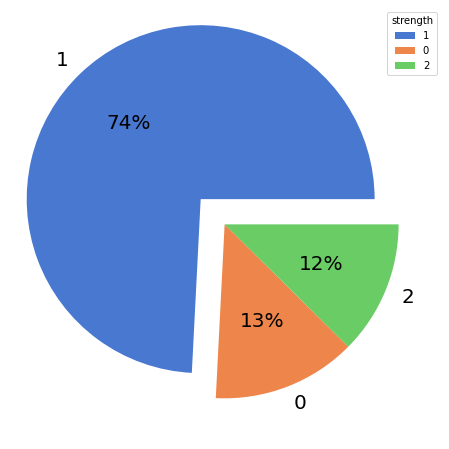

In [120]:
plt.figure(figsize=(8, 8))

values = df['strength'].value_counts().values
labels = df['strength'].value_counts().index
colors = sns.color_palette('muted')[0:3]

plt.pie(
    df['strength'].value_counts().values,
    labels = labels,
    colors = colors,
    explode=[0.2, 0, 0],
    autopct='%.0f%%',
    textprops={'fontsize': 20}
    )

plt.legend(
    title = "strength"
)

plt.show()

We can see that the data is disproportionaly in favour of the strength 1 passwords. 

Although this is unavoidable if most passwords are this strength, it is worth noting, as the models may have a difficult time predicting whether a password is of strength '0' or '2'. 

If you suspect that the models will have an easier time predicting 1 values than the other strengths, you would be right. 

# Data prep

Tokenisation: Deriving a small custom function allows the program to split each
password into individual characters. Passing the function into
sklearn.feature_extraction.text.TfidVectorizer allows the program to ready the
vectorizer which converts the passwords into a usable form for the machine learning
approaches.

In [96]:
def make_chars(inputs):
    characters=[]
    for letter in inputs:
        characters.append(letter)
    return characters

vectorizer=TfidfVectorizer(tokenizer=make_chars)

Use numpy to convert the input and output values to numpy arrays. 

Prep the training and test sets with train_test_split and then transforming the inputs with the vectoriser and fitting them. 

In [97]:
X, y = np.array(df.password), np.array(df.strength)

X_train, X_test, y_train, y_test = train_test_split(vectorizer.fit_transform(X),y, random_state=42)

## Input

You can uncomment out the second line if you would like to test some password. 

In [98]:
password = "!*(&lkjfdaiwa;L!##^$&*#^BS)!#!"
#password = input("Please input a password you would like to test :)... ")

# Data analysis

## Decision tree

A decision tree classifier (DTC) was implemented for NLP. The decision tree derives
the most important features of the dataset by finding which have the highest information
gain. Information gain can be derived through entropy. Those with the higher
information gain are prioritised and placed higher in the tree. These attributes are
evaluated and used to find an if-else statement to begin approximating a class. The tree
is created, containing multiple if-else statements, until it makes leaves (an
approximation of which class the input will be). 

Implement the decision tree classifier. A max depth of 15 is a good middle ground.

In [99]:
DT = DecisionTreeClassifier(max_depth=10)

DT.fit(X_train, y_train)

DT.score(X_test, y_test)

0.8653127053342095

## Logsitic Regression

Logistic regression finds the probability of an input being a certain class. Logistic
regression is similar to linear regression except it instead approximates an input being
true or false. This is done by the model fitting a logistic function between 1 and 0. For this problem, one-vs-the-rest logistic regression (OLR) was required.
OLR splits the dataset, then creates a logistic regression model for each class then picks
the final outcome based on which outcome has the highest score for a given input. 

Implement sklearn.linear_model.LogisticRegression. Specifying multi_class = 'ovr' readies it for multinomianal logistic regression. The rest of the code blocks are almost identical to the decision tree implementation. Same fitting and scoring processing; same confusion matrix and classification processing and testing. 

In [100]:
lr = LogisticRegression(multi_class='ovr',n_jobs=-1)

lr.fit(X_train, y_train)

lr.score(X_test, y_test)

0.8122274655038528

## Evaluation

### Scoring

The below is a confusion matrix containing the true/false positives/negatives for the 3 classes. 

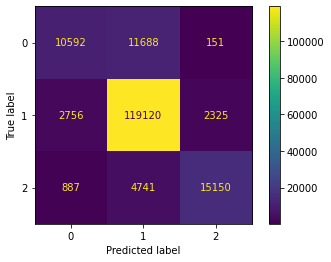

In [101]:
cm = confusion_matrix(y_test,DT.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DT.classes_)
disp.plot()

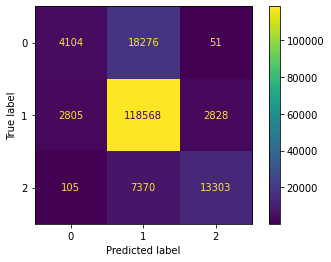

In [102]:
cm = confusion_matrix(y_test,lr.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()

As expected, the models have a lot more support for the '1' strength passwords. 
Because of this, the models had a high level of accuracy for the 1 values because it's weight was significantly heavier than its peers. 

The classification report function gives an overview of the true values and the predictions. Precision, recall and f1-score give more specific accuracy measures for the test.

In [103]:
print(classification_report(y_test,DT.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.47      0.58     22431
           1       0.88      0.96      0.92    124201
           2       0.86      0.73      0.79     20778

    accuracy                           0.87    167410
   macro avg       0.83      0.72      0.76    167410
weighted avg       0.86      0.87      0.86    167410



In [104]:
print(classification_report(y_test,lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.59      0.18      0.28     22431
           1       0.82      0.95      0.88    124201
           2       0.82      0.64      0.72     20778

    accuracy                           0.81    167410
   macro avg       0.74      0.59      0.63    167410
weighted avg       0.79      0.81      0.78    167410



A few noteworthy things here...
* The precision score for linear regression in terms of predicting 0 values is considerably lower than the decision tree.
* The decision tree has better prediction in general for this dataset with an weighted average prediction score of 89% compared to linear regressions 79%.
* We can see in the f1-score in the decision tree is significantly higher than the linear regression score 70% compared to 28%.

The decision tree performed better than the linear regression model. 

The recall score showed a poor result for the 0 scores across the board, just flipping a coin for the decision tree and had even poorer accuracy for linear regression. 

Still, past the issues, the overall accuracy for both models was very good at ~80-90% so both models are appropriate for this problem.

### Predicting

Testing the password. 
* Transform the password
* Predict the password

In [105]:
DT_prob_index = DT.predict(vectorizer.transform([password]))[0]
DT_prob = np.max(DT.predict_proba(vectorizer.transform([password])))

print("The predicted class is {c} with a probability of {p}".format(c=DT_prob_index, p=DT_prob))

The predicted class is 1 with a probability of 0.7493432968867056


In [106]:
lr_prob_index = lr.predict(vectorizer.transform([password]))[0]
lr_prob = np.max(lr.predict_proba(vectorizer.transform([password])))

print("The predicted class is {c} with a probability of {p}".format(c=lr_prob_index, p=lr_prob))

The predicted class is 2 with a probability of 0.9623919896454548


We can see that logistic regression is more confident so this is what I would pick to analyse passwords in the future.